# COGS 108 - EDA Checkpoint

# Names

- Chance Kang
- Lobna Kebir
- Brian Lu
- Sia Sheth
- Aaron Wixson

<a id='research_question'></a>
# Research Question

In a global context, out of the following economical factors related to people’s economic security, which one most strongly influences happiness? 

 * GDP (Gross domestic product, current prices) 
 * Investment (Total investment)
 * Savings (Gross national savings) 
 * CPI (Inflation, average consumer prices)
 * VIGS (Volume of imports of goods and services) 
 * VIG (Volume of Imports of goods)
 * VEGS (Volume of exports of goods and services) 
 * VEG (Volume of exports of goods)
 * Population
 * Revenue (General government revenue) 
 * Expenditure (General government total expenditure)
 * Debt (General government gross debt)
 * Balance (Current account balance) 
 * Unemployment 

Here, happiness is defined by the [World Happiness Report](https://worldhappiness.report/about/), and they use factors such as social support, life expectancy at birth, freedom of choice, confidence in government, and perception of corruption to determine happiness. An in depth econometric analysis of the impact of money categories on happiness, building upon and updating current research.


# Setup

In [17]:
import pandas as pd
import numpy as np
import missingno as msno

pd.options.mode.chained_assignment = None #suppressing SettingWithCopyWarning: used to not set a value

# Data Cleaning

In [18]:
years = ['2012','2013','2014','2015','2016','2017',
'2018','2019','2020','2021','2022'] # years to be observed

#reading csv
weo = pd.read_csv('WEO.csv')
happiness = pd.read_csv('Happiness.csv')

#using set to extract common names
weo_country = set(weo["Country"].unique().tolist())
happiness_country = set(happiness["Country name"].unique().tolist())

common_country = weo_country & happiness_country
weo_not = weo_country - common_country
happiness_not = happiness_country - common_country

print(sorted(happiness_not))
print(sorted(weo_not))

['Congo (Brazzaville)', 'Congo (Kinshasa)', 'Cuba', 'Czechia', 'Gambia', 'Hong Kong S.A.R. of China', 'Iran', 'Ivory Coast', 'Kyrgyzstan', 'Laos', 'Slovakia', 'Somaliland region', 'South Korea', 'State of Palestine', 'Syria', 'Turkiye']
['Andorra', 'Antigua and Barbuda', 'Aruba', 'Barbados', 'Brunei Darussalam', 'Cabo Verde', 'Czech Republic', "CÙte d'Ivoire", 'Democratic Republic of the Congo', 'Dominica', 'Equatorial Guinea', 'Eritrea', 'Fiji', 'Grenada', 'Guinea-Bissau', 'Hong Kong SAR', 'Islamic Republic of Iran', 'Kiribati', 'Korea', 'Kyrgyz Republic', 'Lao P.D.R.', 'Macao SAR', 'Marshall Islands', 'Micronesia', 'Nauru', 'Palau', 'Papua New Guinea', 'Puerto Rico', 'Republic of Congo', 'Samoa', 'San Marino', 'Seychelles', 'Slovak Republic', 'Solomon Islands', 'St. Kitts and Nevis', 'St. Lucia', 'St. Vincent and the Grenadines', 'S„o TomÈ and PrÌncipe', 'The Bahamas', 'The Gambia', 'Timor-Leste', 'Tonga', 'Tuvalu', 'T¸rkiye', 'Vanuatu', 'West Bank and Gaza']


Above is the lists of countries that are not common from both sets of data. 
First is from the Happiness Report and second is from the WEO.

Since some country names are reported different in each of the organizations, we manually matched such countries: 

* Congo (Brazzaville) -> Republic of Congo
* Congo (Kinshasa) -> Democratic Republic of the Congo
* Czechia -> Czech Republic
* Hong Kong S.A.R of China -> Hong Kong SAR
* Iran -> Iran (from Islamic Republic of Iran)
* Kyrgyzstan -> Kyrgyzstan (from Kyrgyz Republic)
* Laos -> Laos (from Lao P.D.R)
* Slovakia -> Slovakia (from Slovak Republic)
* South Korea -> South Korea (from Korea)
* Turkiye -> Turkiye (from T¸rkiye)
* Cuba, Gambia, Ivory Coast, Somaliland region, State of Palestine, Syria - > removed

In [19]:
#replacing left to right
happiness['Country name'].replace(['Congo (Brazzaville)', 'Congo (Kinshasa)', 'Czechia', 'Hong Kong S.A.R. of China'], 
            ['Republic of Congo', 'Democratic Republic of the Congo', 'Czech Republic', 'Hong Kong SAR'], inplace = True)
#replacing right to (from [name])
weo['Country'].replace(['Islamic Republic of Iran', 'Kyrgyz Republic', 'Lao P.D.R.', 'Slovak Republic', 'Korea', 'T¸rkiye'],
                 ['Iran', 'Kyrgyzstan', 'Laos', 'Slovakia', 'South Korea', 'Turkiye'], inplace = True)

#checking
weo_country = set(weo["Country"].unique().tolist())
happiness_country = set(happiness["Country name"].unique().tolist())
common_country = list(sorted(weo_country & happiness_country))
print(common_country)

['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong SAR', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Lithuania', 'Luxembou

The above is the list of countries that are common from both of the lists. 

Note that these countries may not have all entries for variables we are observing and are subjected to be excluded in the later process.

From here on, a single data frame: `data` containing entries from both dataframe will be constructed.

In [20]:
#creating unified data frame: data

#dropping other variables
data = happiness[['Country name', 'year', 'Life Ladder', 'Positive affect', 'Negative affect']] 
#only keeping those after 2012
data.drop(data[data['year'] < 2012].index, inplace = True) 
#numerical year value is no longer needed / potential to influence other num vals
data['year'] = data['year'].apply(str) 

#adding weo variables to data
weo_vars = weo['Subject Descriptor'].unique().tolist()
for var in weo_vars:
    data[var] = np.nan
    
#copying of weo values to data
weo = weo.drop(columns = ['Subject Notes','Units', 'Scale' , 'Country/Series-specific Notes', 'Estimates Start After'])
index = data.index #optain all indices of data
for i in index:
    country = data.loc[i,'Country name'] #get country name from index i
    year = data.loc[i,'year'] #year from index i
    for var in weo_vars: 
        if country in common_country and year in years:
            #accessing values of variables from weo
            temp = weo.loc[(weo['Country'] == country)&(weo['Subject Descriptor'] == var) , year] 
            if temp.empty == False:
                #writing the values of variables from weo to data
                data.at[i,var] = temp[temp.index[0]]

The `data` variable now contains all information from two tables from the years 2012 - 2022 with common countries. 

Some entries of WEO report is missing and are indicated with `string` object `'na'`. 

The following is the cleaning of all invalid inputs.

In [21]:
#'na' to 'NaN' along with changing values to float of WEO variable columns
cols = data.columns.drop(['Country name', 'year'])
data[cols] = data[cols].replace(',','', regex=True)
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')

#dataNA: with missing data for EDA
dataNa = data.copy()

#dropping nans
data = data.dropna()

#index reset
data.reset_index(drop=True, inplace=True)

#column renaming
data.columns = [ 'Country', 'Year', 'LifeLadder', 'PositiveAffect' , 'NegativeAffect',
              'GDP', 'Investment','Savings','CPI','VIGS','VIG','VEGS', 
              'VEG', 'Population', 'Revenue','Expenditure','Debt','Balance','Unemployment']
dataNa.columns = [ 'Country', 'Year', 'LifeLadder', 'PositiveAffect' , 'NegativeAffect',
              'GDP', 'Investment','Savings','CPI','VIGS','VIG','VEGS', 
              'VEG', 'Population', 'Revenue','Expenditure','Debt','Balance','Unemployment']

In [22]:
data.sample(5)

,Country,Year,LifeLadder,PositiveAffect,NegativeAffect,GDP,Investment,Savings,CPI,VIGS,VIG,VEGS,VEG,Population,Revenue,Expenditure,Debt,Balance,Unemployment
823,Sri Lanka,2021,4.103,0.733,0.312,88.979,35.264,31.508,143.433,-4.200,-4.200,2.330,2.330,22.156,8.277,19.913,102.242,-3.757,5.100
878,Turkiye,2013,4.888,0.551,0.392,957.504,29.619,23.898,222.333,8.574,7.300,6.072,-0.901,76.668,32.477,33.936,31.065,-5.754,8.878
566,Moldova,2020,5.812,0.698,0.268,11.530,22.707,15.016,58021.230,-0.503,-0.503,-21.232,-21.232,2.634,31.369,36.686,36.633,-7.692,3.825
339,Greece,2017,5.148,0.516,0.333,199.773,12.022,9.447,119.922,7.370,5.672,8.339,5.803,10.768,49.401,48.496,183.206,-2.575,21.450
553,Mexico,2018,6.550,0.815,0.213,1222.410,22.711,20.576,100.252,6.430,6.325,6.004,6.331,125.328,23.464,25.662,53.649,-2.135,3.323


In [23]:
data.describe()

,LifeLadder,PositiveAffect,NegativeAffect,GDP,Investment,Savings,CPI,VIGS,VIG,VEGS,VEG,Population,Revenue,Expenditure,Debt,Balance,Unemployment
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,9.570000e+02,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,6.023822,0.673699,0.261394,862.806585,24.233908,23.515624,3.637791e+11,3.612152,3.363675,3.795066,3.483728,51.427169,32.123559,34.966494,59.512265,-0.785276,8.273465
std,0.878277,0.103091,0.077786,2561.397406,6.696299,8.009748,3.428097e+12,9.336150,9.136029,9.997717,8.914282,149.661064,11.401578,10.968666,37.705957,6.602507,5.635202
min,3.559000,0.297000,0.083000,1.784000,5.111000,-3.957000,4.019400e+01,-50.061000,-50.061000,-43.078000,-43.078000,0.320000,5.117000,9.761000,0.055000,-43.825000,0.700000
25%,5.381000,0.594000,0.204000,46.607000,20.030000,18.282000,9.932500e+01,-0.127000,-0.670000,0.260000,-0.519000,5.128000,23.633000,27.066000,36.629000,-4.092000,4.797000
50%,6.007000,0.698000,0.253000,215.681000,23.272000,22.873000,1.049090e+02,3.868000,3.564000,3.707000,3.180000,10.554000,31.937000,35.429000,51.929000,-1.216000,6.617000
75%,6.648000,0.753000,0.308000,535.328000,26.600000,27.866000,1.317980e+02,8.094000,7.640000,7.811000,6.888000,46.300000,40.342000,42.657000,75.927000,2.637000,9.835000
max,7.889000,0.884000,0.552000,25464.480000,56.417000,58.697000,4.196422e+13,48.744000,42.502000,84.109000,64.411000,1412.600000,71.975000,69.920000,261.289000,45.462000,35.300000


# Data Analysis & Results (EDA)

In [24]:
'''
converting Year to int
DO CONVERT BACK TO STRING WHEN YEAR DOES NOT NEED TO BE INT
'''
data["Year"] = data["Year"].astype(int)

### Function
`consec_years(df,year1,year2)`
* Input: `df` as dataframe, `year1`,`year2` as int
* Output: `df_r` as dataframe
* Description: returns a copy of dataframe that includes only the countries that have consecutive years of data in range [`year1`,`year2`]

In [25]:
#writte by Chance Kang for returning subset of dataframe with countries that have consecutive years data
def consec_years(df, year1, year2):
    #containing countries with consecutive data
    curr_country = set(data[data["Year"] == year1].Country.unique().tolist())
    #increment year1
    while year1 <= year2:
        #update interscetion with current year's list
        curr_country = curr_country and set(data[data["Year"] == year1].Country.unique())
        year1+=1
    #extract names of countries to remove
    to_remove = list(set(data["Country"].unique().tolist()) - curr_country)
    #copy to preserve
    df_r = df.copy()
    #drop with names
    df_r = df_r.drop(df_r[df_r.Country.isin(to_remove)].index)
    return df_r

### EDA START


In [26]:
#dataNa for NaN data analysis
print(dataNa.shape)
#data for cleaned
print(data.shape)

(1487, 19)
(957, 19)


The shape of `dataNa` shows that we have dropped about half of observations from missing data. Following will analyze the missing data. 

<Axes: >

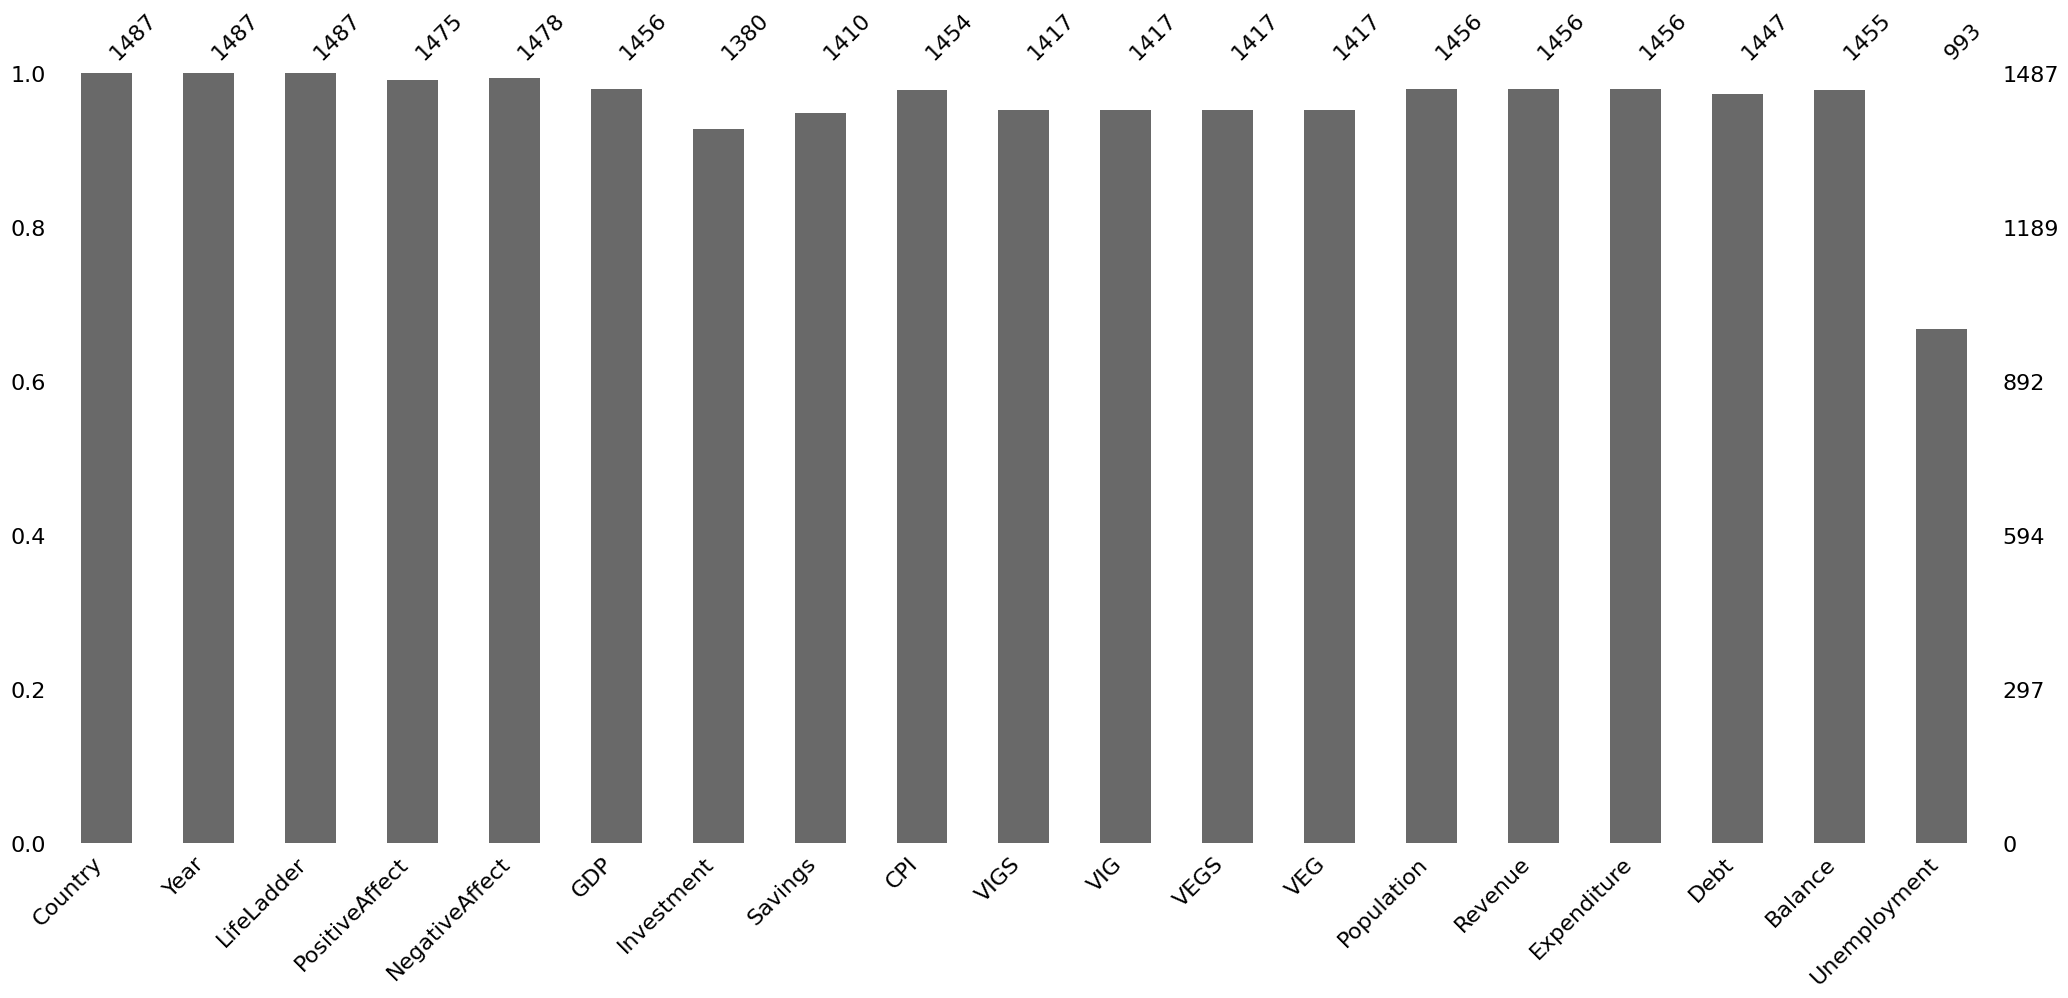

In [27]:
msno.bar(dataNa)

`Unemployment` variable reports relatively high number of missing values.

<Axes: >

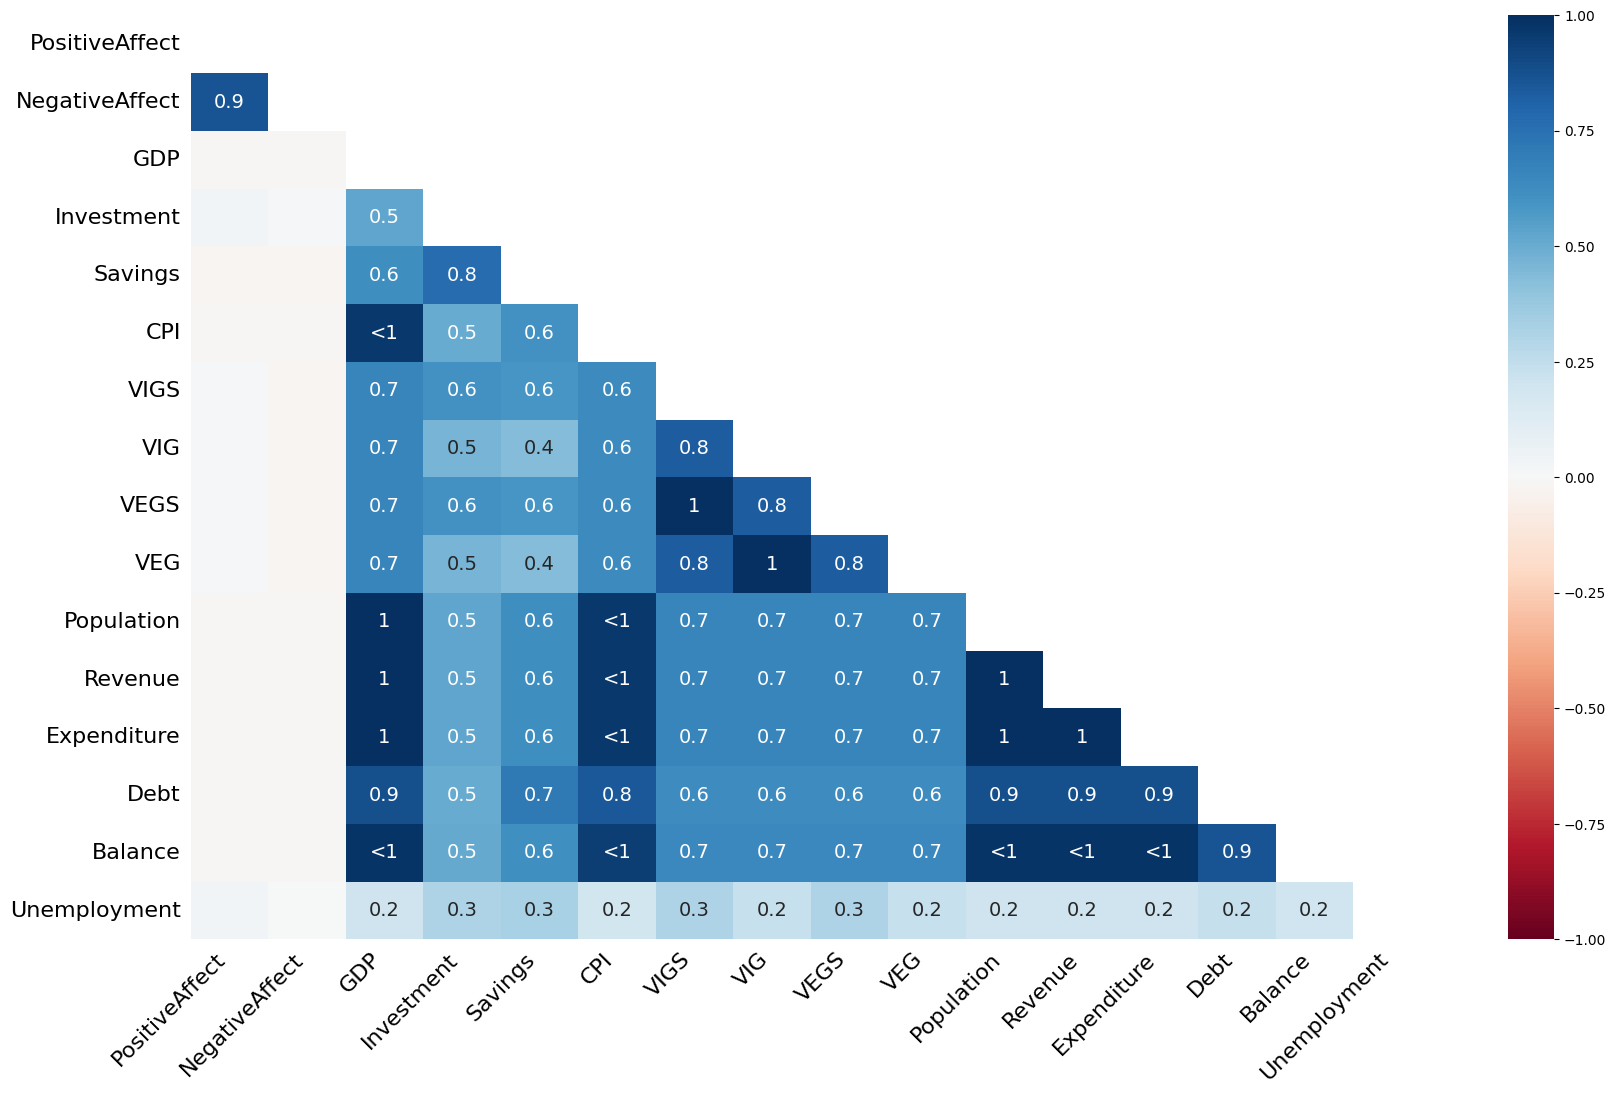

In [28]:
msno.heatmap(dataNa)

The heatmap shows that many other economic factors given by `WEO` are also missing when an economic factor is missing.

In [29]:
unemp_Na = dataNa[dataNa['Unemployment'].isnull()]
print(unemp_Na.Country.unique())
print(unemp_Na.Year.unique())

['Afghanistan' 'Algeria' 'Angola' 'Bangladesh' 'Benin' 'Botswana'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Central African Republic'
 'Chad' 'Comoros' 'Republic of Congo' 'Democratic Republic of the Congo'
 'Eswatini' 'Ethiopia' 'Gabon' 'Gambia' 'Ghana' 'Guatemala' 'Guinea'
 'Haiti' 'India' 'Iraq' 'Ivory Coast' 'Jamaica' 'Kenya' 'Kosovo' 'Laos'
 'Lebanon' 'Lesotho' 'Liberia' 'Libya' 'Madagascar' 'Malawi' 'Maldives'
 'Mali' 'Mauritania' 'Montenegro' 'Mozambique' 'Myanmar' 'Namibia' 'Nepal'
 'Niger' 'Nigeria' 'Qatar' 'Rwanda' 'Saudi Arabia' 'Senegal'
 'Sierra Leone' 'Somalia' 'Somaliland region' 'South Sudan'
 'State of Palestine' 'Syria' 'Tajikistan' 'Tanzania' 'Togo'
 'Trinidad and Tobago' 'Tunisia' 'Turkmenistan' 'Uganda'
 'United Arab Emirates' 'Venezuela' 'Yemen' 'Zambia' 'Zimbabwe']
['2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2021' '2022'
 '2020']


In [30]:
ie_Na = dataNa[(dataNa['Population'].isnull()) | (dataNa['Revenue'].isnull()) | (dataNa['Expenditure'].isnull()) 
               | (dataNa['Debt'].isnull()) | (dataNa['Balance'].isnull()) | (dataNa['GDP'].isnull())]
print(ie_Na.Country.unique())
print(ie_Na.Year.unique())

['Afghanistan' 'Bulgaria' 'Gambia' 'Ivory Coast' 'Lebanon' 'Libya'
 'Somalia' 'Somaliland region' 'State of Palestine' 'Syria']
['2021' '2022' '2015' '2017' '2018' '2019' '2013' '2014' '2016' '2020'
 '2012']


The missing values for the dataset exists for all observed years. 

However, the countries with missing data seems to show some overlap with majority of countries with missing data on economic factors also showing up in the list of countries with missing data for `Unemployment` variable. At a glance, the countries listed above are often considered developing countries, yet data from some developing countries such as `Vietnam` does exist. 

WEO reports, [" All of the data that can be released to the public are already incorporated into the WEO online database. Missing data in the table downloads and CSV files are indeed unavailable and not a result of a technical issue ... Some indicators are not included in the online database and are reserved for IMF staff research (IMF working papers, IMF staff reports, etc.)".](https://www.imf.org/en/Publications/WEO/frequently-asked-questions) Hence, the data itself is more likely that it is not availabe for the public than being biased. 